In [1]:
import datetime
import pathlib
import pandas as pd

## Part 1: Data Pre-Processing

In [2]:
def generate_weekly_aggregate(input):
    return input.groupby("open_covid_region_code").resample("W-Mon", on="date").sum().reset_index()

def clean_by_columns(input, threshold=0.60):
    # drop column where its all nan
    input.dropna(axis=1, inplace=True, how="all")
    # drop the columns less than 60% valid entries or whatever's specified
    input.dropna(axis=1, inplace=True, thresh=input.shape[0]*threshold)

def clean_by_region(input):
    return input.groupby("open_covid_region_code").filter(lambda x: x["hospitalized_new"].sum()>0).reset_index().drop(columns="index")

def merge_data(a, b):
    return pd.merge(a, b, on=["open_covid_region_code", "date"], how="left")

In [3]:
# Google Search CSV Data
search_trend = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv")
print("shape of raw dataframe: {}".format(search_trend.shape))
clean_by_columns(search_trend)
for col_name in ["country_region", "country_region_code", "sub_region_1_code"]:
  search_trend.drop(col_name, axis=1, inplace=True)
print("shape of processed dataframe: {}".format(search_trend.shape))
print("number of regions: {}".format(len(search_trend.sub_region_1.unique())))

shape of raw dataframe: (640, 430)
shape of processed dataframe: (640, 18)
number of regions: 16


In [4]:
# Hospitalization Data
hospitalization = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv", low_memory=False)
hospitalization= hospitalization[hospitalization["open_covid_region_code"].str.contains("US-")]
print("shape of raw dataframe: {}".format(hospitalization.shape))
clean_by_columns(hospitalization)
hospitalization.date = pd.to_datetime(hospitalization.date)
hospitalization = clean_by_region(hospitalization)
# aggregate daily data to weekly
hospitalization = generate_weekly_aggregate(hospitalization)
hospitalization["date"] = hospitalization["date"].astype(str)
print("shape of processed dataframe: {}".format(hospitalization.shape))
print("number of regions: {}".format(len(hospitalization.open_covid_region_code.unique())))

shape of raw dataframe: (12821, 62)
shape of processed dataframe: (1239, 4)
number of regions: 37


In [5]:
# Merge Data
merged = merge_data(search_trend, hospitalization)
merged = merged.fillna(0)
print("shape of merged dataframe: {}".format(merged.shape))
merged.head()
print("number of regions: {}".format(len(merged.sub_region_1.unique())))

shape of merged dataframe: (640, 20)
number of regions: 16


## Part 2 - Visualization

In [6]:
!pip install plotly==4.8

# the plots only works with plotly==4.8


In [7]:
# visualization imports
import plotly.express as px
import plotly.graph_objects as go

import sklearn

Task 2.1

In [8]:
# Plotly is a great open source graphing library from Montreal :))
# Let's support the local businesses :))

# For each symptom, draw a density heatmap and a bar chart

for symptom in merged.columns:
  if symptom.startswith('symptom:'):

#density heatmap
    fig = px.density_heatmap(merged, x="date", y="sub_region_1", z=symptom,
                            width=1000, height=600,nbinsx=39,
                            labels={
                              "date": "Date",
                              "sub_region_1": "Regions"
                            },
                            title="Heatmap for the Weekly Volume of Searches for " + symptom)

    fig.show()

# bar chart
    fig2 = px.bar(merged, x="date", y=symptom, color="sub_region_1", 
                  labels={
                    "date": "Date",
                    "open_covid_region_code": "Regions"
                  },
                  title="Total Weekly Volume of Searches for " + symptom)
    fig2.show()

In [9]:
#distribution chart

symptom_list = []

for symptom in merged.columns:
  if symptom.startswith('symptom:'):
    symptom_list.append(symptom)

# get the list of dates
dates_list = merged.date.unique()
nb_of_dates = len(dates_list)


average_df =  pd.DataFrame(data={"regions": merged.sub_region_1.unique()})

for symptom in symptom_list:
  average_df[symptom] = [None] * len(merged.sub_region_1.unique())

  for region_index in range(0, len(merged.sub_region_1.unique())):
    sum = 0
    for date_index in range(0, nb_of_dates):
      sum += merged[symptom][39*region_index + date_index]

    average = sum / nb_of_dates

    average_df[symptom][region_index] = average


for symptom in symptom_list:
  dist_df =  pd.DataFrame(data={'date':dates_list, '< 0.5':[0] * nb_of_dates, '< 0.7': [0] * nb_of_dates, '< 0.9': [0] * nb_of_dates, 
                              '< 1.1': [0] * nb_of_dates, '< 1.3': [0] * nb_of_dates, '< 1.5': [0] * nb_of_dates, 
                              '< 1.7': [0] * nb_of_dates, '>= 1.7': [0] * nb_of_dates})
  
  for region_index in range(0, len(merged.sub_region_1.unique())):
    for date_index in range(0, nb_of_dates):

      current_region_freq = merged[symptom][39*region_index + date_index]
      current_region_average = average_df[symptom][region_index]

      if current_region_freq < 0.5 * current_region_average:
        dist_df['< 0.5'][date_index] += 1
      elif current_region_freq < 0.7 * current_region_average:
        dist_df['< 0.7'][date_index] += 1
      elif current_region_freq < 0.9 * current_region_average:
        dist_df['< 0.9'][date_index] += 1
      elif current_region_freq < 1.1 * current_region_average:
        dist_df['< 1.1'][date_index] += 1
      elif current_region_freq < 1.3 * current_region_average:
        dist_df['< 1.3'][date_index] += 1
      elif current_region_freq < 1.5 * current_region_average:
        dist_df['< 1.5'][date_index] += 1
      elif current_region_freq < 1.7 * current_region_average:
        dist_df['< 1.7'][date_index] += 1
      else:
        dist_df['>= 1.7'][date_index] += 1

  fig3 = go.Figure()
  fig3.update_layout(
    template="simple_white",
    barmode="stack",
  )

  colors = ['#ffffff', '#00ff00', '#7de800', '#aad000', '#cab500', '#e29700', '#f27600', '#fc4f00', '#ff0000' ]
  for bin, color in zip(dist_df.columns, colors):
    if bin != 'date':
      fig3.add_trace(
          go.Bar(x=dist_df.date, y=dist_df[bin], name=bin, marker_color=color)
      )

  fig3.update_layout(height=600, width=800,
                     xaxis_title="Date",
                     yaxis_title="Number of States", 
                     title="Ratio of Weekly Volume of Searches per Region for " + symptom)
  fig3.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is tryi

Task 2.2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler

copy_data = merged.copy(deep=True)
copy_data = copy_data.drop(columns=['open_covid_region_code', 'sub_region_1', 'date', 
                                                           'hospitalized_new', 'hospitalized_cumulative'])

stdScaler = StandardScaler()

scaled_data = stdScaler.fit_transform(copy_data)


# print(scaled_data)

imputer = SimpleImputer(missing_values = np.nan, strategy='median')

new_data = imputer.fit_transform(scaled_data)


pca = decomposition.PCA(n_components=10)
pca.fit(new_data)
pca_data = pca.transform(new_data)

percent_values = pca.explained_variance_ratio_
labels = ['Principal Component ' + str(x) for x in range(1, len(percent_values)+1)]

pca_percent_df = pd.DataFrame(data={'labels': labels, 'percent': percent_values})


fig = px.bar(pca_percent_df, x="labels", y="percent", title="Scree Plot for PCA")
fig.update_layout(
    height=600, width=800,
    xaxis_title="Principal Component Number",
    yaxis_title="Eigenvalue",
)
fig.show()

Scatter Plot for PCA Visualization

In [11]:
# print(pca_data[0])
column_names = []
for pca_index in range(1, len(pca_data[0])+1):
  column_names.append("pca" + str(pca_index))


scatter_pca_df = pd.DataFrame(data=pca_data, columns=column_names)

In [12]:
# import plotly.express as px
fig = px.scatter(scatter_pca_df, x='pca1', y='pca2',
                 labels={
        'pca1': "Principal Component 1",
        'pca2': "Principal Component 2"
    })
fig.update_layout(
    height=600, width=800,
    title="Scatter Plot for PCA"

)
fig.show()

Task 2.3: Clustering


In [13]:

from sklearn import mixture

from scipy import linalg

import itertools

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])



In [14]:
# Function to plot the data into a scatter plot with colors for each group
def plot_results(X, Y_, title, axis1_title, axis2_title, original_data, component_no_1, component_no_2):

    column_names = []
    for dim_index in range(1, len(X[0])+1):
      column_names.append("c" + str(dim_index))

    plot_df = pd.DataFrame(data=X, columns=column_names)

    plot_df = plot_df.assign(group = np.char.mod('%d', Y_)) 
    plot_df = plot_df.assign(date = original_data.date) 
    plot_df = plot_df.assign(region = original_data.sub_region_1) 

    fig = px.scatter(plot_df, x='c'+str(component_no_1), y='c'+str(component_no_2),
                    labels={
            'c'+str(component_no_1): axis1_title,
            'c'+str(component_no_2): axis2_title
        }, color="group",
        hover_data=["date", "region"])
    fig.update_layout(
        height=600, width=800,
        title=title

    )
    fig.show()

Clustering with Raw Data

In [15]:
# Copying the raw data
cluster_data_raw = scaled_data.copy()

Create a Scree Plot using the BIC values to see how many components to use with the EM algorithm

In [16]:
n_components_array = np.arange(1, 10)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster_data_raw)
          for n in n_components_array]

bic_list = [m.bic(cluster_data_raw) for m in models]
min_bic_value, n_components_i = min((min_bic_value, n_components_i) for (n_components_i, min_bic_value) in enumerate(bic_list))
n_components = n_components_array[n_components_i]
print("By BIC, the number of components that we need will be: ", n_components)

# Scree Plot for the BIC values
fig = go.Figure()

fig.add_trace(go.Scatter(x=n_components_array, y=bic_list,
                    mode='lines+markers',
                    name='lines+markers'))


# Add the title and axis titles
fig.update_layout(title='Scree Plot for the BIC by the Number of Components',
                   xaxis_title='Number of Components',
                   yaxis_title='BIC',
                  hovermode="x unified")

fig.show()

By BIC, the number of components that we need will be:  6


In [17]:
# Compare the Variances of each of the symptoms
n_columns = len(cluster_data_raw[0])

columns = [[]] * n_columns
for i in range(3, n_columns + 3):
  columns[i-3] = merged.iloc[:, i]


columns_variances = [0]*n_columns
for i in range(0, n_columns):
  columns_variances[i] = np.var(columns[i])


print(columns_variances)
# Seems like the 2nd and the 15th symptoms have the largest variances and thus let's use these to plot the scatter plots

[87.15839733984417, 223.86230100561457, 36.72246804467782, 82.60664588964889, 82.96392590234396, 68.56557943749992, 204.4740837490228, 58.88436761621104, 55.81241292871103, 46.38857702905263, 100.5982257773444, 67.8491938710938, 46.916139892334115, 63.83141491967773, 303.45836469506725]


In [18]:

# Clustering of Raw data using the EM algorithm for a Gaussian Mixture Model
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(cluster_data_raw)

raw_predictions = gmm.predict(cluster_data_raw)

plot_results(cluster_data_raw, raw_predictions, 'Clustering of Raw data using the EM algorithm for a Gaussian Mixture Model',
             "Component 1", "Component 2", merged, 2, 15)



Clustering with PCA Dimension Reduced data

In [19]:
# Copying the pca data
cluster_data_pca = pca_data.copy()


Create a Scree Plot using the BIC values to see how many components to use with the EM algorithm

In [20]:
n_components_array = np.arange(1, 10)
models = [mixture.GaussianMixture(n, covariance_type='full').fit(cluster_data_pca) for n in n_components_array]

bic_list = [m.bic(cluster_data_pca) for m in models]
min_bic_value, n_components_i = min((min_bic_value, n_components_i) for (n_components_i, min_bic_value) in enumerate(bic_list))
n_components = n_components_array[n_components_i]
print("By BIC, the number of components that we need will be: ", n_components)


# Scree Plot for the BIC values
fig = go.Figure()

fig.add_trace(go.Scatter(x=n_components_array, y=bic_list,
                    mode='lines+markers',
                    name='lines+markers'))


# Add the title and axis titles
fig.update_layout(title='Scree Plot for the BIC by the Number of Components',
                   xaxis_title='Number of Components',
                   yaxis_title='BIC')

fig.show()


By BIC, the number of components that we need will be:  6


In [21]:

# Clustering of PCA data using the EM algorithm for a Gaussian Mixture Model
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(cluster_data_pca)

pca_predictions = gmm.predict(cluster_data_pca)
plot_results(cluster_data_pca, pca_predictions, 'Clustering of PCA data using the EM algorithm for a Gaussian Mixture Model', 
             "Principal Component 1", "Principal Component 2", merged, 1,2)


In [22]:
# Clustering of Raw data using the EM algorithm for a Gaussian Mixture Model
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(cluster_data_raw)

raw_predictions = gmm.predict(cluster_data_raw)

# since the data in both the pca and the raw are in the exact same order
# we know that the first element in cluster_data_pca corresponds to the first element in cluster_data_raw
# all the way until their last elements
# which is why we can plot the cluster_data_pca using the raw_predictions
# this will be in effect computing the GMM cluster predictions and then using PCA to reduce the dimensionality of the dataset 
# to then be able to plot it in the same principal component space as the PCA dataset
# this is so that we can visually compare the 2 
plot_results(cluster_data_pca, raw_predictions, 'Clustering of PCA data using the EM algorithm for a Gaussian Mixture Model', 
             "Principal Component 1", "Principal Component 2", merged, 1,2)

Comparing the Results from the Raw and the PCA Clustering

In [23]:
# function to compare similarities between 2 arrays
# returns ratio of similarities

def similarities(array1, array2):
  # creates a set
  compare_set = set()

# Adds all the elements from the first array into the set
  for element in array1:
    compare_set.add(element)

# checks the number of elements that are the same in both arrays (no matter the order)
  n_same = 0
  # for each element in the second array,
  # if the element is already in the set
  # then we add one to the number of same elements
  for element in array2:
    if element in compare_set:
      n_same += 1
  
  # return the number of same elements divided by the average size of the 2 arrays
  return round((n_same / ((len(array1) + len(array2))/2)), 2)

In [24]:


n_groups = len(np.unique(raw_predictions))

raw_groups_list = [0] * n_groups
for raw_el in raw_predictions:
  raw_groups_list[raw_el] += 1

pca_groups_list = [0] * n_groups
for pca_el in pca_predictions:
  pca_groups_list[pca_el] += 1


print(raw_groups_list)

print(pca_groups_list)


[12, 121, 359, 40, 65, 43]
[120, 54, 199, 161, 40, 66]


Get the PCA clusters and the raw clusters back into arrays

In [25]:
n_groups_raw = len(np.unique(raw_predictions))
n_el_raw = len(raw_predictions)

data_dict_list = merged.T.to_dict().values()

raw_groups_dict = { }

for i in range(0, n_groups_raw):
  raw_groups_dict[str(i)] = []

for group_no, dict_el in zip(raw_predictions, data_dict_list):
  raw_groups_dict[str(group_no)].append(dict_el) 



In [26]:
n_groups = len(np.unique(raw_predictions))
n_el = len(pca_predictions)

data_dict_list = merged.T.to_dict().values()

groups_dict = { }

for i in range(0, n_groups):
  groups_dict[str(i)] = []

for group_no, dict_el in zip(pca_predictions, data_dict_list):
  groups_dict[str(group_no)].append(dict_el) 



In [27]:
#function to turn list dict of data points into str
def listdict_to_str(listdict):
  str_list = []
  for el in listdict:
    str1 = el['sub_region_1'] + "," + str(el['date'])
    str_list.append(str1)

  return str_list

In [28]:
# Compare each of the groups using my algorithm
compare_g0_array = [0] * n_groups_raw
for i in range(0, n_groups_raw):
  sim = similarities(listdict_to_str(groups_dict['0']), listdict_to_str(raw_groups_dict[str(i)]))
  compare_g0_array[i] = sim

compare_g1_array = [1] * n_groups_raw
for i in range(0, n_groups_raw):
  sim = similarities(listdict_to_str(groups_dict['1']), listdict_to_str(raw_groups_dict[str(i)]))
  compare_g1_array[i] = sim

compare_g2_array = [2] * n_groups_raw
for i in range(0, n_groups_raw):
  sim = similarities(listdict_to_str(groups_dict['2']), listdict_to_str(raw_groups_dict[str(i)]))
  compare_g2_array[i] = sim

compare_g3_array = [3] * n_groups_raw
for i in range(0, n_groups_raw):
  sim = similarities(listdict_to_str(groups_dict['3']), listdict_to_str(raw_groups_dict[str(i)]))
  compare_g3_array[i] = sim

compare_g4_array = [4] * n_groups_raw
for i in range(0, n_groups_raw):
  sim = similarities(listdict_to_str(groups_dict['4']), listdict_to_str(raw_groups_dict[str(i)]))
  compare_g4_array[i] = sim

compare_g5_array = [5] * n_groups_raw
for i in range(0, n_groups_raw):
  sim = similarities(listdict_to_str(groups_dict['5']), listdict_to_str(raw_groups_dict[str(i)]))
  print(sim)
  compare_g5_array[i] = sim


0.31
0.0
0.0
0.0
0.82
0.0


In [29]:

from plotly.offline import iplot
import plotly.figure_factory as ff

nqsv_data=[compare_g0_array, compare_g1_array, compare_g2_array, compare_g3_array, compare_g4_array, compare_g5_array]

layout_heatmap = go.Layout(
    title=('Clusters Similarities between PCA and Raw'),
    xaxis=dict(title='PCA Clusters'), 
    yaxis=dict(title='Raw Data Clusters', dtick=1),
    width=400,
    height=400
)

ff_fig = ff.create_annotated_heatmap(z=nqsv_data, showscale = True)
fig  = go.FigureWidget(ff_fig)
fig.layout=layout_heatmap
fig.layout.annotations = ff_fig.layout.annotations
fig.data[0].colorbar = dict(title='Similarity', titleside = 'right')

iplot(fig)

In [30]:
# Compute the average of the largest NQSV of each cluster pair
max_nqsv_list = [0] * n_groups_raw

for i in range(0, n_groups_raw):
  cur_max = np.max(nqsv_data[i])
  max_nqsv_list[i] = cur_max

average_nqsv = np.average(max_nqsv_list)

print("The average NQSV of all cluster pairs is: ", average_nqsv)

The average NQSV of all cluster pairs is:  0.8400000000000002


Get the PCA Clusters into arrays for further usage


In [31]:
n_groups = len(np.unique(raw_predictions))
n_el = len(pca_predictions)

data_dict_list = merged.T.to_dict().values()

group0 = []
group1 = []
group2 = []
group3 = []
group4 = []
group5 = []

groups_dict = { }

for i in range(0, n_groups):
  groups_dict[str(i)] = []

for group_no, dict_el in zip(pca_predictions, data_dict_list):
  if group_no == 0:
    group0.append(dict_el)
  elif group_no == 1:
    group1.append(dict_el)
  elif group_no == 2:
    group2.append(dict_el)
  elif group_no == 3:
    group3.append(dict_el)
  elif group_no == 4:
    group4.append(dict_el)
  elif group_no == 5:
    group5.append(dict_el)

  groups_dict[str(group_no)].append(dict_el) 



In [32]:
n_groups = len(np.unique(raw_predictions))
n_el = len(pca_predictions)
# groups_list= [[]*n_el]*n_groups

data_dict_list = merged.T.to_dict().values()

# print(len(groups_list))

group0 = []
group1 = []
group2 = []
group3 = []
group4 = []
group5 = []

for group_no, dict_el in zip(pca_predictions, data_dict_list):
  # groups_list[group_no].append(dict_el)

  if group_no == 0:
    group0.append(dict_el)
  elif group_no == 1:
    group1.append(dict_el)
  elif group_no == 2:
    group2.append(dict_el)
  elif group_no == 3:
    group3.append(dict_el)
  elif group_no == 4:
    group4.append(dict_el)
  elif group_no == 5:
    group5.append(dict_el)



## Part 3 - Predict New Hospitalization Case by Symptom Search Trend

In [33]:
import time
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, cross_val_score
from sklearn.decomposition import PCA

PCA reduction on the features

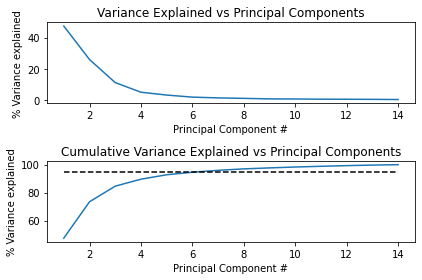

In [34]:
all_features = merged.iloc[:, 3:-3]

pca = PCA()
pca.fit(all_features)
pca_features_reduced = pca.transform(all_features)[:,:5]
num_pc_components = len(pca.explained_variance_ratio_)
plt.subplot(2,1,1)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca.explained_variance_ratio_)
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Variance Explained vs Principal Components")

plt.subplot(2,1,2)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),95*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Cumulative Variance Explained vs Principal Components")

plt.tight_layout()

Examining Correlation to select features

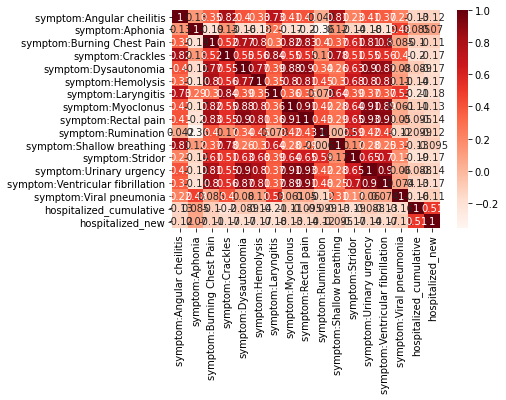

symptom:Crackles                    0.168758
symptom:Dysautonomia                0.170119
symptom:Hemolysis                   0.166524
symptom:Laryngitis                  0.181555
symptom:Stridor                     0.174906
symptom:Ventricular fibrillation    0.165549
hospitalized_cumulative             0.511670
hospitalized_new                    1.000000
Name: hospitalized_new, dtype: float64


In [35]:
cor = merged.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
cor_target = abs(cor["hospitalized_new"])
relevant_features = cor_target[cor_target>0.15]
print(relevant_features)
features_selected = merged[["symptom:Laryngitis",  "symptom:Stridor", "symptom:Crackles", "symptom:Dysautonomia" ]]

Training and tuning of hyperparameters

In [36]:
def train_and_tune_hyperparameters(x, y, groups=None):
  knn_params = {
      'leaf_size': list(range(1,5)), 
      'n_neighbors': list(range(1,5)), 
      'p': [1, 2]
  }
  dtree_params = {
    'criterion': ['mse', 'mae'],
    'max_depth': [2,4,6,8,10,12]      
  }
  if groups is None:
    start = time.time()
    knn_search = RandomizedSearchCV(KNeighborsRegressor(), knn_params, 
                                    cv=5, scoring="neg_mean_absolute_error",
                                    random_state=42)
    knn_best = knn_search.fit(x, y)
    print(f"KNN Training Time: {time.time() - start}")

    start = time.time()
    dtree_search = RandomizedSearchCV(DecisionTreeRegressor(), dtree_params, 
                                      cv=5, scoring="neg_mean_absolute_error",
                                      random_state=42)
    dtree_best = dtree_search.fit(x, y)
    print(f"DT Training Time: {time.time() - start}")

  else:
    start = time.time()
    knn_search = RandomizedSearchCV(KNeighborsRegressor(), knn_params, 
                                    cv=GroupKFold(n_splits=5),
                                    scoring="neg_mean_absolute_error",
                                    random_state=42)
    knn_best = knn_search.fit(x, y, groups=groups)
    print(f"KNN Training Time: {time.time() - start}")
    
    start = time.time()
    dtree_search = RandomizedSearchCV(DecisionTreeRegressor(), dtree_params, 
                                      cv=GroupKFold(n_splits=5),
                                      scoring="neg_mean_absolute_error",
                                      random_state=42)
    dtree_best = dtree_search.fit(x, y, groups=groups) 
    print(f"DT Training Time: {time.time() - start}")

  return knn_best, dtree_best

def cross_validation(model, x, y, groups):
  results = cross_val_score(model, x, y, cv=GroupKFold(n_splits=5), 
                            groups=groups, 
                            scoring="neg_mean_absolute_error")
  return results.mean()




KNN and Decision Tree Regressor on region-split dataset ( Including 5-Fold Cross Validation )

In [37]:
regions = merged["open_covid_region_code"]
date = merged["date"]

# All Features
X_region = all_features.to_numpy()
# Labels
Y = merged["hospitalized_new"]
Y_region = merged["hospitalized_new"].to_numpy()

# prepare groups used for training
region_map = {k: i for i, k in enumerate(regions.unique())}
region_group = regions.map(region_map)

# training and tuning
knn_regressor, dtree_regressor = train_and_tune_hyperparameters(X_region, Y_region, groups=region_group)
knn_regressor_modified, dtree_regressor_modified = train_and_tune_hyperparameters(features_selected.to_numpy(), Y_region, groups=region_group)
knn_regressor_reduced, dtree_regressor_reduced = train_and_tune_hyperparameters(pca_features_reduced, Y_region, groups=region_group)


print("\n -- Splitting Method: REGION -- ")
print("\nKNN:")
print("Training With Original Feature Set:")
print(f"- Best Model Parameters: {knn_regressor.best_params_}")
print(f"- Cross Validation Error: {cross_validation(knn_regressor.best_estimator_, X_region, Y_region, region_group)*-1}")
print("With Selected Feature Set:")
print(f"- Best Model Parameters: {knn_regressor_modified.best_params_}")
print(f"- Cross Validation Error: {cross_validation(knn_regressor_modified.best_estimator_, X_region, Y_region, region_group)*-1}")
print("With PCA Reduced Feature Set:")
print(f"- Best Model Parameters: {knn_regressor_reduced.best_params_}")
print(f"- Cross Validation Error: {cross_validation(knn_regressor_reduced.best_estimator_, X_region, Y_region, region_group)*-1}")

print("\n -- Splitting Method: REGION -- ")
print("\nDecision Trees:")
print("Training With Original Feature Set:")
print(f"- Best Model Parameters: {dtree_regressor.best_params_}")
print(f"- Cross Validation Error {cross_validation(dtree_regressor.best_estimator_, X_region, Y_region, region_group)*-1}")
print("With Selected Feature Set:")
print(f"- Best Model Parameters: {dtree_regressor_modified.best_params_}")
print(f"- Cross Validation Error {cross_validation(dtree_regressor_modified.best_estimator_, X_region, Y_region, region_group)*-1}")
print("With PCA Reduced Feature Set:")
print(f"- Best Model Parameters:  {dtree_regressor_reduced.best_params_}")
print(f"- Cross Validation Error: {cross_validation(dtree_regressor_reduced.best_estimator_, X_region, Y_region, region_group)*-1}")

KNN Training Time: 0.3886995315551758
DT Training Time: 0.9108884334564209
KNN Training Time: 0.163560152053833
DT Training Time: 0.38170599937438965
KNN Training Time: 0.16313457489013672
DT Training Time: 0.5433576107025146

 -- Splitting Method: REGION -- 

KNN:
Training With Original Feature Set:
- Best Model Parameters: {'p': 2, 'n_neighbors': 4, 'leaf_size': 2}
- Cross Validation Error: 30.951874999999994
With Selected Feature Set:
- Best Model Parameters: {'p': 1, 'n_neighbors': 3, 'leaf_size': 2}
- Cross Validation Error: 32.35444444444445
With PCA Reduced Feature Set:
- Best Model Parameters: {'p': 1, 'n_neighbors': 3, 'leaf_size': 2}
- Cross Validation Error: 32.35444444444445

 -- Splitting Method: REGION -- 

Decision Trees:
Training With Original Feature Set:
- Best Model Parameters: {'max_depth': 4, 'criterion': 'mae'}
- Cross Validation Error 31.760624999999997
With Selected Feature Set:
- Best Model Parameters: {'max_depth': 4, 'criterion': 'mae'}
- Cross Validation Err

KNN and Decision Tree Regressor on date-split dataset

In [38]:
def split_by_timepoint(df, timepoint="2020-08-10"):
  val = df.loc[(df['date'] >= "2020-08-10")]
  x_val = val.iloc[:, 1:-1].fillna(0).to_numpy()
  y_val = val["hospitalized_new"].to_numpy()

  train = df.loc[(df['date'] < "2020-08-10")]
  x_train = train.iloc[:, 1:-1].fillna(0).to_numpy()
  y_train = train["hospitalized_new"].to_numpy()
  return x_train, x_val, y_train, y_val


from sklearn.metrics import mean_absolute_error

x_train, x_val, y_train, y_val = split_by_timepoint(pd.concat([date, all_features, Y], axis=1))

x_train_modified, x_val_modified, y_train_modified, y_val_modified = split_by_timepoint(pd.concat([date, features_selected, Y], axis=1))
reduced_df = pd.DataFrame(pca_features_reduced)
x_train_reduced, x_val_reduced, y_train_reduced, y_val_reduced = split_by_timepoint(pd.concat([date, reduced_df, Y], axis=1))

# training and tuning
knn_regressor, dtree_regressor = train_and_tune_hyperparameters(x_train, y_train)
knn_regressor_modified, dtree_regressor_modified = train_and_tune_hyperparameters(x_train_modified, y_train_modified)
knn_regressor_reduced, dtree_regressor_reduced = train_and_tune_hyperparameters(x_train_reduced, y_train_reduced)

print("\n -- Splitting Method: DATE -- ")
print("\nKNN:")
print("With original feature set:")
print(f"- Best Model Parameters: {knn_regressor.best_params_}")
y_pred_knn = knn_regressor.best_estimator_.predict(x_val)
print(f"- Mean Absolute Error: {mean_absolute_error(y_pred_knn, y_val)}")
print("With selected feature set:")
print(f"- Best Model Parameters: {knn_regressor_modified.best_params_}")
y_pred_knn = knn_regressor_modified.best_estimator_.predict(x_val_modified)
print(f"- Mean Absolute Error:: {mean_absolute_error(y_pred_knn, y_val_modified)}")
print("With reduced feature set:")
print(f"- Best Model Parameters: {knn_regressor_reduced.best_params_}")
y_pred_knn = knn_regressor_reduced.best_estimator_.predict(x_val_reduced)
print(f"- Mean Absolute Error: {mean_absolute_error(y_pred_knn, y_val_reduced)}")

print("\n -- Splitting Method: DATE -- ")
print("\nDecision Trees:")
print("With original feature set:")
print(f"- Best Model Parameters: {dtree_regressor.best_params_}")
y_pred_dtree = dtree_regressor.best_estimator_.predict(x_val)
print(f"- Mean Absolute Error: {mean_absolute_error(y_pred_dtree, y_val)}")
print("With selected feature set:")
print(f"- Best Model Parameters: {dtree_regressor_modified.best_params_}")
y_pred_dtree = dtree_regressor_modified.best_estimator_.predict(x_val_modified)
print(f"- Mean Absolute Error: {mean_absolute_error(y_pred_dtree, y_val_modified)}")
print("With reduced feature set:")
print(f"- Best Model Parameters: {dtree_regressor_reduced.best_params_}")
y_pred_knn = dtree_regressor_reduced.best_estimator_.predict(x_val_reduced)
print(f"- Mean Absolute Error: {mean_absolute_error(y_pred_knn, y_val_reduced)}")

KNN Training Time: 0.24283933639526367
DT Training Time: 0.6655149459838867
KNN Training Time: 0.14370942115783691
DT Training Time: 0.24915623664855957
KNN Training Time: 0.13491296768188477
DT Training Time: 0.3562760353088379

 -- Splitting Method: DATE -- 

KNN:
With original feature set:
- Best Model Parameters: {'p': 2, 'n_neighbors': 4, 'leaf_size': 2}
- Mean Absolute Error: 32.88194444444444
With selected feature set:
- Best Model Parameters: {'p': 2, 'n_neighbors': 4, 'leaf_size': 2}
- Mean Absolute Error:: 40.013888888888886
With reduced feature set:
- Best Model Parameters: {'p': 2, 'n_neighbors': 4, 'leaf_size': 2}
- Mean Absolute Error: 35.04340277777778

 -- Splitting Method: DATE -- 

Decision Trees:
With original feature set:
- Best Model Parameters: {'max_depth': 4, 'criterion': 'mae'}
- Mean Absolute Error: 39.548611111111114
With selected feature set:
- Best Model Parameters: {'max_depth': 4, 'criterion': 'mae'}
- Mean Absolute Error: 42.03125
With reduced feature se

Task 3.3 - Implementing Neural Network Regressor on region-split and date-split data



In [39]:
#To disable convergence warning when training the neural network
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPRegressor

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.



In [40]:
@ignore_warnings(category=ConvergenceWarning)
def train_and_tune_hyperparameters_neuralNetwork(x, y, groups=None):
  neuralnetwork_params = {
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd','adam'],
    'batch_size':[16,32,64]
  }

  if groups is None:
    start = time.time()
    neuralnetwork_search = RandomizedSearchCV(MLPRegressor(shuffle=False), neuralnetwork_params, 
                                      cv=5, scoring="neg_mean_absolute_error",
                                      random_state=42)
    neuralnetwork_best = neuralnetwork_search.fit(x, y)
    print(f"Neural Network Training Time: {time.time() - start}")
  else:
    start = time.time()
    neuralnetwork_search = RandomizedSearchCV(MLPRegressor(shuffle=False), neuralnetwork_params, 
                                      cv=GroupKFold(n_splits=5), scoring="neg_mean_absolute_error",
                                      random_state=42)
    neuralnetwork_best = neuralnetwork_search.fit(x, y, groups=groups)
    print(f"Neural Network Training Time: {time.time() - start}")
  return neuralnetwork_best

# training and tuning for region split data
neuralnetwork_regressor = train_and_tune_hyperparameters_neuralNetwork(X_region, Y_region, groups=region_group)
neuralnetwork_regressor_modified = train_and_tune_hyperparameters_neuralNetwork(features_selected.to_numpy(), Y_region, groups=region_group)

print("\n -- Splitting Method: REGION -- ")
print("\nNeural Network:")
print("With original feature set:")
print(f"- Best Model Parameters: {neuralnetwork_regressor.best_params_}")
print(f"- Cross Validation Error: {cross_validation(neuralnetwork_regressor.best_estimator_, X_region, Y_region, region_group)*-1}")
print("With selected feature set:")
print(f"- Best Model Parameters: {neuralnetwork_regressor_modified.best_params_}")
print(f"- Cross Validation Error: {cross_validation(neuralnetwork_regressor_modified.best_estimator_, X_region, Y_region, region_group)*-1}\n")

# training and tuning for date split data
neuralnetwork_regressor = train_and_tune_hyperparameters_neuralNetwork(x_train, y_train)
neuralnetwork_regressor_modified = train_and_tune_hyperparameters_neuralNetwork(x_train_modified, y_train_modified)

print("\n -- Splitting Method: DATE -- ")
print("\nNeural Network:")
print("With original feature set:")
print(f"- Best Model Parameters: {neuralnetwork_regressor.best_params_}")
y_pred_neuralnetwork = neuralnetwork_regressor.best_estimator_.predict(x_val)
print(f"- Mean Absolute Error: {mean_absolute_error(y_pred_neuralnetwork, y_val)}")
print("With selected feature set:")
print(f"- Best Model Parameters: {neuralnetwork_regressor_modified.best_params_}")
y_pred_neuralnetwork = neuralnetwork_regressor_modified.best_estimator_.predict(x_val_modified)
print(f"- Mean Absolute Error: {mean_absolute_error(y_pred_neuralnetwork, y_val_modified)}")

Neural Network Training Time: 54.75869655609131
Neural Network Training Time: 52.996009349823

 -- Splitting Method: REGION -- 

Neural Network:
With original feature set:
- Best Model Parameters: {'solver': 'adam', 'batch_size': 64, 'activation': 'tanh'}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

- Cross Validation Error: 30.276333938384205
With selected feature set:
- Best Model Parameters: {'solver': 'adam', 'batch_size': 64, 'activation': 'tanh'}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

- Cross Validation Error: 30.150340977424918

Neural Network Training Time: 43.84627342224121
Neural Network Training Time: 43.04392957687378

 -- Splitting Method: DATE -- 

Neural Network:
With original feature set:
- Best Model Parameters: {'solver': 'adam', 'batch_size': 64, 'activation': 'tanh'}
- Mean Absolute Error: 33.101836599897325
With selected feature set:
- Best Model Parameters: {'solver': 'adam', 'batch_size': 64, 'activation': 'relu'}
- Mean Absolute Error: 39.07851900245161
